In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from tqdm.notebook import tqdm

# On désactive l'import direct de DQN pour le remplacer
# from stable_baselines3 import DQN  
from stable_baselines3.common.vec_env import DummyVecEnv

# ===================================
# LIGNES AJOUTÉES pour le Double DQN 
# (Custom) 
# ===================================
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.utils import polyak_update
import pickle


import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Load data

In [8]:
commodities = ['GC=F', 'SI=F', 'NG=F']

def get_commodities_data(tickers, start="2010-01-01", end="2023-01-01", interval="1d"):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end, interval=interval)
        data[ticker] = df
    return data

commodities_data = get_commodities_data(commodities)

# Définition des périodes
training_data_time_range = ('2010-01-01', '2017-12-31')
validation_data_time_range = ('2018-01-01', '2019-12-31')
test_data_time_range = ('2020-01-01', '2023-01-01')

training_data = {}
validation_data = {}
test_data = {}

for ticker, df in commodities_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]].copy()
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]].copy()
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]].copy()

print("Shapes pour GC=F (Training, Validation, Test) :", 
      training_data['GC=F'].shape, validation_data['GC=F'].shape, test_data['GC=F'].shape)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shapes pour GC=F (Training, Validation, Test) : (2011, 5) (502, 5) (756, 5)


In [9]:
def add_technical_indicators(df):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
    df['CCI'] = (tp - sma_tp) / (0.015 * mean_dev)

    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    df['+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    df['-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    tr = pd.concat([df['High'] - df['Low'], 
                    np.abs(df['High'] - df['Close'].shift(1)), 
                    np.abs(df['Low'] - df['Close'].shift(1))], axis=1).max(axis=1)
    atr = tr.ewm(span=14, adjust=False).mean()
    df['+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)
    df['-DI'] = 100 * (df['-DM'].ewm(span=14, adjust=False).mean() / atr)
    dx = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = dx.ewm(span=14, adjust=False).mean()
    df['BB_Mid'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Mid'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Mid'] - 2 * df['BB_Std']
    df['ROC'] = df['Close'].pct_change(periods=10) * 100
    df['Volume'] = np.log1p(df['Volume'])  # Pour aplatir les grosses valeurs
    df['Volume'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()


    
    df.dropna(inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX', 'BB_Mid', 'BB_Std', 'BB_Upper', 'BB_Lower']]
    return df

for ticker in training_data:
    training_data[ticker] = add_technical_indicators(training_data[ticker])
for ticker in validation_data:
    validation_data[ticker] = add_technical_indicators(validation_data[ticker])
for ticker in test_data:
    test_data[ticker] = add_technical_indicators(test_data[ticker])

print(training_data['GC=F'].head())

Price              Open         High          Low        Close    Volume  \
Ticker             GC=F         GC=F         GC=F         GC=F      GC=F   
Date                                                                       
2010-02-01  1081.000000  1107.300049  1076.800049  1104.300049  0.903026   
2010-02-02  1117.400024  1118.500000  1100.199951  1117.400024  0.935696   
2010-02-03  1115.800049  1124.900024  1108.599976  1111.400024  0.423703   
2010-02-04  1110.000000  1110.699951  1059.000000  1062.400024  0.571229   
2010-02-05  1052.199951  1068.500000  1045.199951  1052.199951  0.616585   

Price            MACD    Signal        RSI         CCI        ADX  \
Ticker                                                              
Date                                                                
2010-02-01  -8.662289 -5.106665  34.836633  -65.366222  28.495614   
2010-02-02  -6.795084 -5.444349  46.015247  -10.964782  26.065814   
2010-02-03  -5.733371 -5.502153  41.246502   -

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour ajouter les bandes de Bollinger
def add_bollinger_bands(df, window=20):
    df = df.copy()
    df['BB_Mid'] = df['Close'].rolling(window=window).mean()
    df['BB_Std'] = df['Close'].rolling(window=window).std()
    df['BB_Upper'] = df['BB_Mid'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Mid'] - 2 * df['BB_Std']
    return df.dropna()

# Ajout des indicateurs
for ticker in commodities:
    commodities_data[ticker] = add_bollinger_bands(commodities_data[ticker])

# Environment

In [4]:
class CommodityTradingEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self, commodity_data, transaction_cost_percent=0.005, initial_balance=10000):
        super(CommodityTradingEnv, self).__init__()
        
        self.commodity_data = {ticker: df for ticker, df in commodity_data.items() if not df.empty}
        self.tickers = list(self.commodity_data.keys())
        if not self.tickers:
            raise ValueError("Aucune donnée disponible pour les commodities.")
        
        sample_df = next(iter(self.commodity_data.values()))
        self.n_features = len(sample_df.columns)

        self.recent_actions = {ticker: [] for ticker in self.tickers} 
        
        # Espace d'actions discret (inchangé)
        self.action_list = [-1, -0.75, -0.50, -0.25, 0, 0.25, 0.50, 0.75, 1]
        self.num_actions_per_commodity = len(self.action_list)
        self.action_space = spaces.Discrete(self.num_actions_per_commodity ** len(self.tickers))
        
        # Espace d'observation
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)
        
        self.initial_balance = initial_balance 
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        
        self.current_step = 0
        self.max_steps = max(0, min(len(df) for df in self.commodity_data.values()) - 1)
        self.transaction_cost_percent = transaction_cost_percent
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0
        return self._next_observation(), {}
    
    def _next_observation(self):
        frame = np.zeros(self.obs_shape)
        idx = 0
        for ticker in self.tickers:
            df = self.commodity_data[ticker]
            if self.current_step < len(df):
                frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            else:
                frame[idx:idx+self.n_features] = df.iloc[-1].values
            idx += self.n_features
        
        # Ajout des informations supplémentaires
        frame[-4-len(self.tickers)] = self.balance
        frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers]
        frame[-3] = self.net_worth
        frame[-2] = self.max_net_worth
        frame[-1] = self.current_step
        
        return frame
    
    def decode_action(self, action):
        decoded_indices = []
        temp = action
        n = len(self.tickers)
        for _ in range(n):
            decoded_indices.append(temp % self.num_actions_per_commodity)
            temp //= self.num_actions_per_commodity
        decoded_indices.reverse()
        decoded_actions = [self.action_list[idx] for idx in decoded_indices]
        return decoded_actions
    
    def step(self, action):
        if isinstance(action, np.ndarray):
            action = int(action[0])
        actions = self.decode_action(action)
        
        prev_net_worth = self.net_worth
        self.current_step += 1
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}

        penalty = 0
        current_prices = {}

        for i, ticker in enumerate(self.tickers):
            price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])
            act = actions[i]
            current_prices[ticker] = price

            # Ajout de l'action actuelle à l'historique
            self.recent_actions[ticker].append(act)
            if len(self.recent_actions[ticker]) > 15:
                self.recent_actions[ticker].pop(0)

            if act < 0 and self.shares_held[ticker] <= 0:
                penalty -= 0.05

            # --- EXÉCUTION DES ACTIONS ---
            if act > 0:  # Achat
                shares_to_buy = int(self.balance * act / price)
                cost = shares_to_buy * price
                transaction_cost = cost * self.transaction_cost_percent
                self.balance -= (cost + transaction_cost)
                self.shares_held[ticker] += shares_to_buy

            elif act < 0 and self.shares_held[ticker] > 0:  # Vente
                shares_to_sell = int(self.shares_held[ticker] * abs(act))
                sale = shares_to_sell * price
                transaction_cost = sale * self.transaction_cost_percent
                self.balance += (sale - transaction_cost)
                self.shares_held[ticker] -= shares_to_sell
                self.total_shares_sold[ticker] += shares_to_sell
                self.total_sales_value[ticker] += sale

        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
        self.max_net_worth = max(self.net_worth, self.max_net_worth)
        reward = (self.net_worth - prev_net_worth) / prev_net_worth + penalty


        


        done = self.net_worth <= 0 or self.current_step >= self.max_steps
        return self._next_observation(), reward, done, False, {}
    
    def render(self, mode='human'):
        profit = self.net_worth - self.initial_balance
        print(f"Step: {self.current_step}")
        print(f"Balance: {self.balance:.2f}")
        for ticker in self.tickers:
            print(f"{ticker} Shares held: {self.shares_held[ticker]}")
        print(f"Net worth: {self.net_worth:.2f} | Profit: {profit:.2f}")
    
    def close(self):
        pass

# Agent

In [5]:
class BollingerBaselineAgent:
    def __init__(self, env):
        """
        A simple, rule-based Bollinger baseline agent.
        Assumptions:
         - The observation for each asset contains:
             • The asset’s “Close” price at index (base_idx + 3)
             • A Bollinger upper value at index (base_idx + 12)
             • A Bollinger lower value at index (base_idx + 13)
         - When the current price is below the lower band, the agent issues a full buy signal.
         - When the current price is above the upper band, it issues a full sell signal.
         - Otherwise, it holds (no action).
         - The agent uses the environment’s discrete action space. 
        """
        self.env = env.envs[0] if hasattr(env, "envs") else env
        self.n_features = env.envs[0].n_features


    def predict(self, obs, state=None, episode_start=None, deterministic=True):
        """
        Determines the action based on Bollinger signals.
        For each asset:
          - if Close < bb_lower => full buy (1.0)
          - if Close > bb_upper => full sell (-1.0)
          - else hold (0.0)
        The continuous signals are then mapped to the closest discrete action defined in env.action_list.
        """
        tickers = self.env.tickers
        n = len(tickers)
        actions = []
        obs = obs[0]  # Retire la dimension superflue
        
        for i in range(n):
            base_idx = i * self.n_features
            # Extract the necessary features from the observation.
            # Adjust the indices if your observation structure is different.
            close = obs[base_idx + 3]
            bb_upper = obs[base_idx + 12]
            bb_lower = obs[base_idx + 13]
            
            if close < bb_lower:
                actions.append(1.0)    # Signal full buy
            elif close > bb_upper:
                actions.append(-1.0)   # Signal full sell
            else:
                actions.append(0.0)    # Hold
        
        # Convert continuous signals into the discrete action index.
        action = self.encode_action(actions)
        return action, None

    def encode_action(self, action_vector):
        """
        Maps a vector of continuous action signals to a single discrete action integer.
        Uses the environment's action_list and number of actions per commodity.
        """
        def closest(val):
            return min(range(len(self.env.action_list)), key=lambda i: abs(val - self.env.action_list[i]))
        
        index = 0
        base = self.env.num_actions_per_commodity
        for val in action_vector:
            idx = closest(val)
            index = index * base + idx
        return index

    def save(self, path):
        """Saves the agent via pickle."""
        with open(path, "wb") as f:
            pickle.dump(self, f)
    
    @classmethod
    def load(cls, path):
        """Loads a previously saved agent."""
        with open(path, "rb") as f:
            return pickle.load(f)

# Training Agent

In [6]:
env_train = DummyVecEnv([lambda: CommodityTradingEnv(training_data, transaction_cost_percent=0.005)])
env_val = DummyVecEnv([lambda: CommodityTradingEnv(validation_data, transaction_cost_percent=0.005)])
env_test = DummyVecEnv([lambda: CommodityTradingEnv(test_data, transaction_cost_percent=0.005)])

In [7]:
agent = BollingerBaselineAgent(env_train)

best_val_reward = -np.inf
best_model_path = "best_bollinger_baseline_agent.pkl"
num_epochs = 10
timesteps_per_epoch = 1000

train_rewards = []
val_rewards = []

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    obs = env_train.reset()
    done = False
    cumulative_train_reward = 0
    t = 0
    
    while not done and t < timesteps_per_epoch:
        action, _ = agent.predict(obs)
        obs, reward, done, _ = env_train.step([action])
        cumulative_train_reward += reward[0]
        t += 1

    train_rewards.append(cumulative_train_reward)
    print(f"Training Reward: {cumulative_train_reward:.2f}")
    
    # --- Evaluation on the validation environment ---
    val_obs = env_val.reset()
    done = False
    cumulative_val_reward = 0
    while not done:
        action, _ = agent.predict(val_obs)
        val_obs, reward, done, _ = env_val.step([action])
        cumulative_val_reward += reward[0]

    val_rewards.append(cumulative_val_reward)
    print(f"Validation Cumulative Reward: {cumulative_val_reward:.2f}")
    
    # Save the best performing agent.
    if cumulative_val_reward > best_val_reward:
        best_val_reward = cumulative_val_reward
        agent.save(best_model_path)
        print(f"New best model saved with validation reward = {best_val_reward:.2f}")

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


=== Epoch 1/10 ===


C:\Users\planc\AppData\Local\Temp\ipykernel_14636\2847975497.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])


Training Reward: -6.34
Validation Cumulative Reward: -4.98
New best model saved with validation reward = -4.98

=== Epoch 2/10 ===
Training Reward: -6.34
Validation Cumulative Reward: -4.98

=== Epoch 3/10 ===
Training Reward: -6.34
Validation Cumulative Reward: -4.98

=== Epoch 4/10 ===
Training Reward: -6.34
Validation Cumulative Reward: -4.98

=== Epoch 5/10 ===
Training Reward: -6.34
Validation Cumulative Reward: -4.98

=== Epoch 6/10 ===
Training Reward: -6.34
Validation Cumulative Reward: -4.98

=== Epoch 7/10 ===
Training Reward: -6.34
Validation Cumulative Reward: -4.98

=== Epoch 8/10 ===
Training Reward: -6.34
Validation Cumulative Reward: -4.98

=== Epoch 9/10 ===
Training Reward: -6.34
Validation Cumulative Reward: -4.98

=== Epoch 10/10 ===
Training Reward: -6.34
Validation Cumulative Reward: -4.98


# Testing Agent

In [64]:
def test_agent(env, model, n_tests, visualize=False):
    metrics = {
        'steps': [],  # Les pas de l'agent
        'balances': [],  # Les balances des comptes
        'net_worths': [],  # Le Net Worth à chaque étape
        'shares_held': {ticker: [] for ticker in env.envs[0].commodity_data.keys()}  # Quantité de chaque actif détenu
    }
    
    obs = env.reset()
    for i in range(n_tests):
        metrics['steps'].append(i)
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step([action])
        if visualize:
            env.envs[0].render()  # Option pour visualiser à chaque étape
        metrics['balances'].append(env.envs[0].balance)  # Ajouter la balance de l'agent
        metrics['net_worths'].append(env.envs[0].net_worth)  # Ajouter le Net Worth de l'agent
        for ticker in env.envs[0].commodity_data.keys():
            metrics['shares_held'][ticker].append(env.envs[0].shares_held[ticker])  # Quantité des actions détenues
        if done:
            obs = env.reset()  # Réinitialiser l'environnement si l'épisode est terminé
    return metrics

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_net_worth(test_metrics, env):
    """
    Affiche l'évolution du Net Worth avec les dates réelles en abscisse.
    """
    # Récupération des dates depuis l'index du DataFrame (on prend le 1er ticker comme référence)
    df_index = env.envs[0].commodity_data[env.envs[0].tickers[0]].index
    
    # On aligne les dates avec la longueur des steps testés
    dates = df_index[:len(test_metrics['net_worths'])]

    # Création du graphique
    plt.figure(figsize=(12,6))
    plt.plot(dates, test_metrics['net_worths'], label="Net Worth", color='blue', linewidth=1.8)
    plt.title("Évolution du Net Worth sur le set de Test")
    plt.xlabel("Date")
    plt.ylabel("Net Worth")
    plt.grid(True)
    plt.legend()

    # Formatage de la date en abscisse
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

In [65]:
# Charger le modèle sauvegardé
best_model = BollingerBaselineAgent.load(best_model_path)

# Réinitialisation de l'environnement de test
obs = env_test.reset()
done = False
test_cumulative_reward = 0

# Boucle de test de l'agent
while not done:
    # Prédire l'action à partir de l'observation actuelle
    action, _ = best_model.predict(obs)
    
    # Exécuter l'action dans l'environnement
    obs, reward, done, info = env_test.step([action])
    
    # Cumul des récompenses obtenues
    test_cumulative_reward += reward[0]  # reward[0] si la récompense est un tableau ou une liste

# Afficher la récompense cumulative du test
print("Test cumulative reward:", test_cumulative_reward)


C:\Users\planc\AppData\Local\Temp\ipykernel_22252\2847975497.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])


Test cumulative reward: -5.3041945


C:\Users\planc\AppData\Local\Temp\ipykernel_22252\2847975497.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])


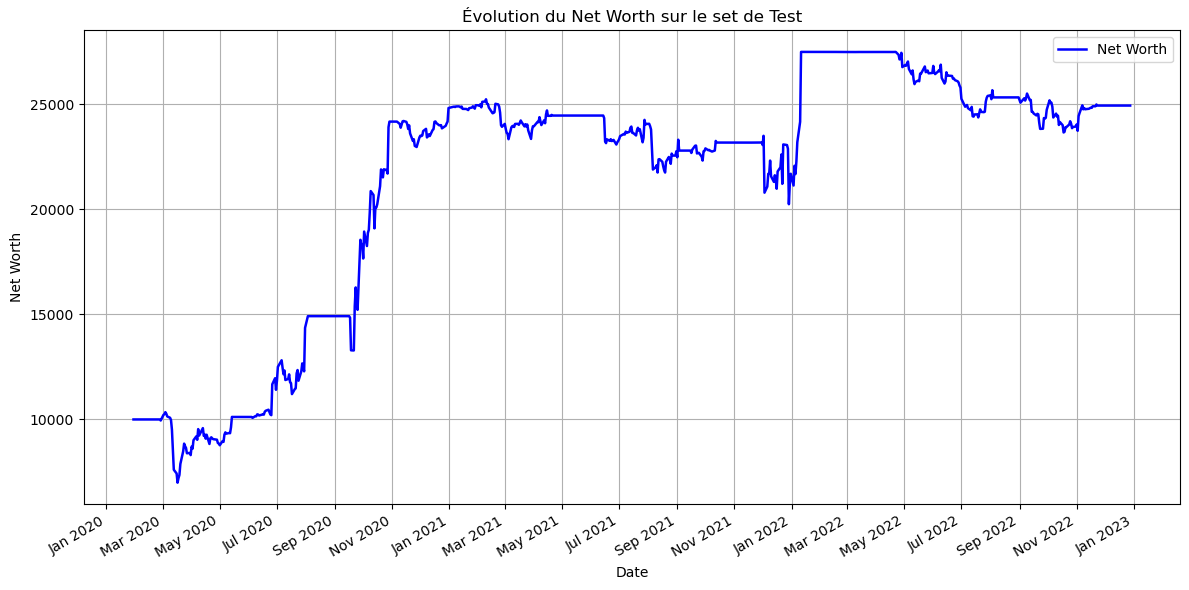

In [66]:
max_days = env_test.envs[0].max_steps - 1  # Nombre d'étapes dans l'environnement de test
test_metrics = test_agent(env_test, best_model, n_tests=max_days, visualize=False)  # Test de l'agent

# Affichage de l'évolution du Net Worth
plot_net_worth(test_metrics=test_metrics, env=env_test)

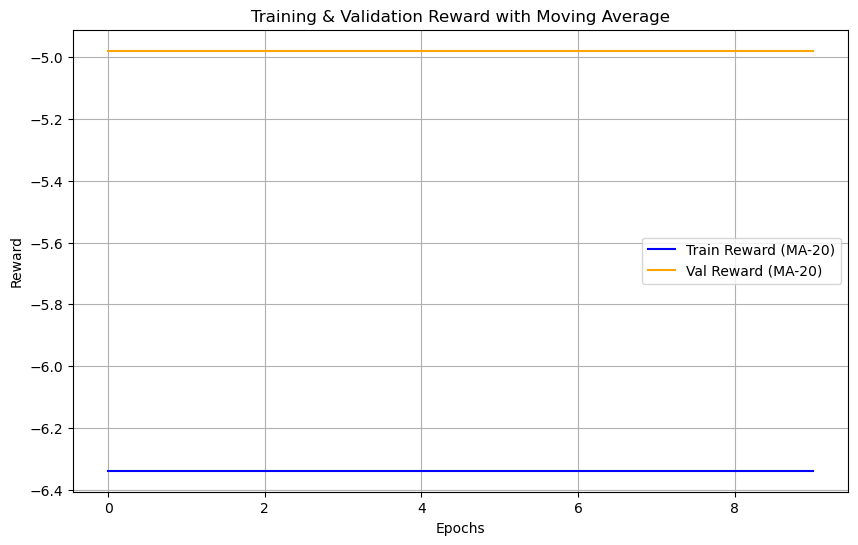

In [67]:
def plot_rewards(epochs, train_rewards, val_rewards, window_size=10):
    """
    Trace les courbes de récompenses (train & validation) avec une moyenne mobile.
    
    Parameters:
    - epochs: Liste des epochs
    - train_rewards: Liste des récompenses d'entraînement
    - val_rewards: Liste des récompenses de validation
    - window_size: Taille de la fenêtre pour la moyenne mobile (par défaut 10)
    """
    # Calcul de la moyenne mobile (rolling mean)
    # train_rewards_ma = pd.Series(train_rewards).rolling(window=window_size).mean()
    # val_rewards_ma = pd.Series(val_rewards).rolling(window=window_size).mean()

    # Tracer les courbes avec les moyennes mobiles
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_rewards, label=f'Train Reward (MA-{window_size})', color='blue')
    plt.plot(epochs, val_rewards, label=f'Val Reward (MA-{window_size})', color='orange')
    plt.title("Training & Validation Reward with Moving Average")
    plt.xlabel("Epochs")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.legend()
    plt.show()


# Supposons que tu as rempli train_losses, val_losses à chaque epoch
epochs_list = range(num_epochs)
plot_rewards(epochs_list, train_rewards, val_rewards, window_size=20)

C:\Users\planc\AppData\Local\Temp\ipykernel_22252\2847975497.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])


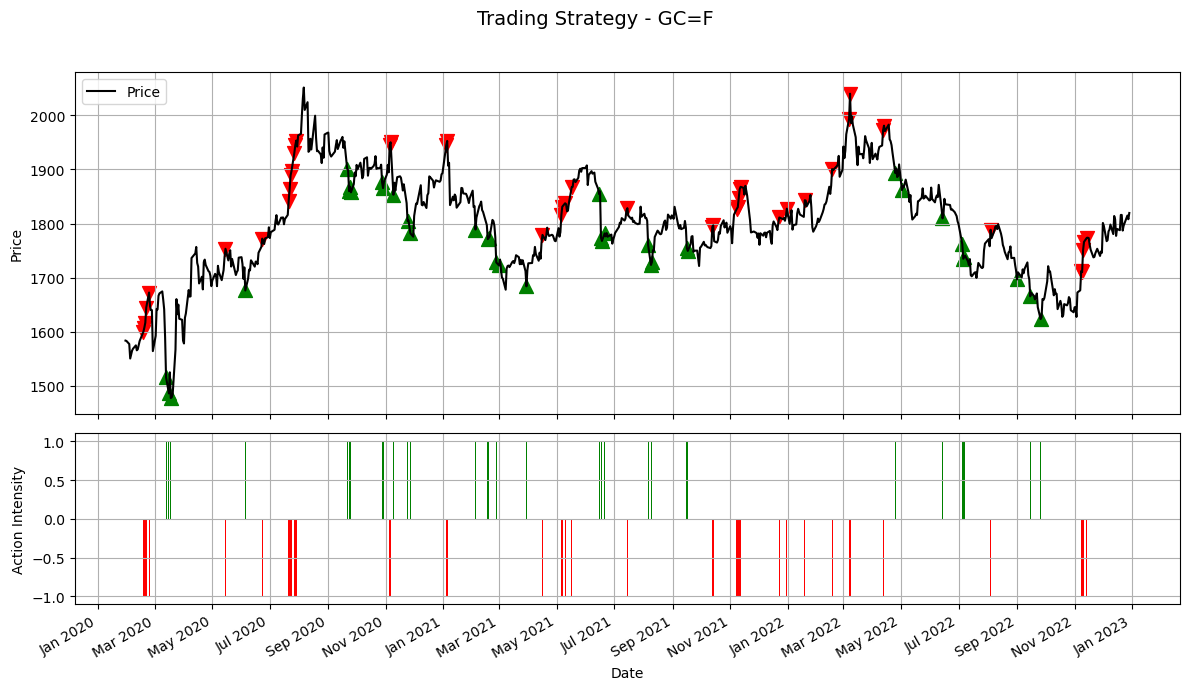

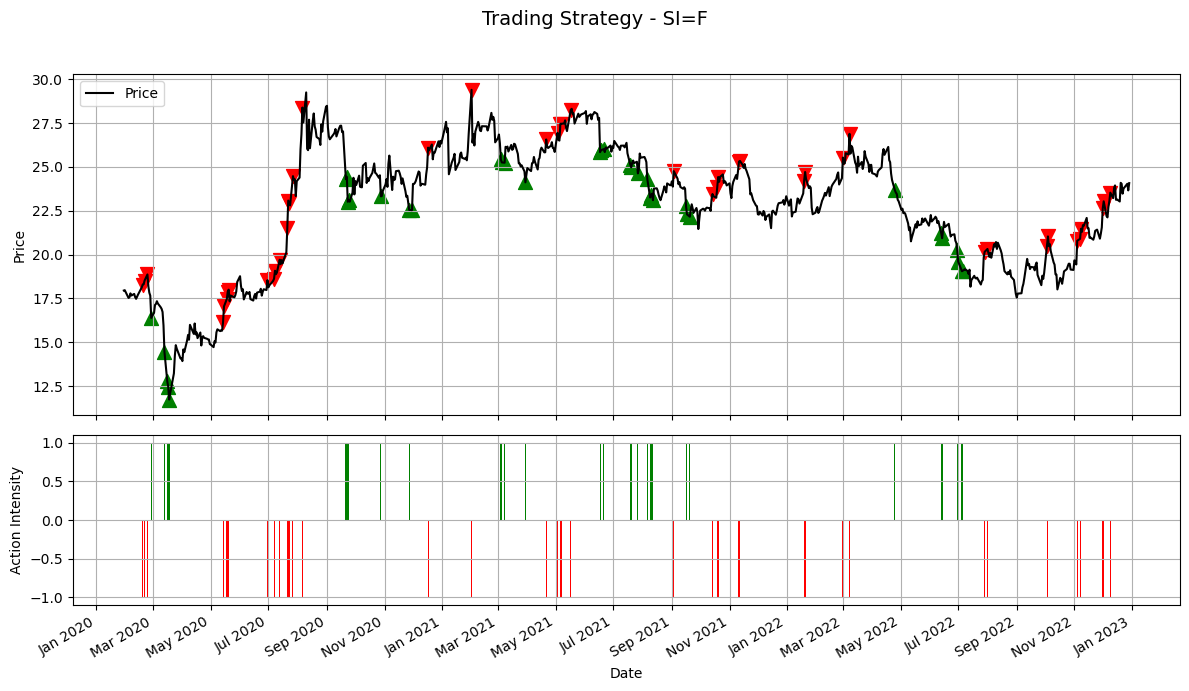

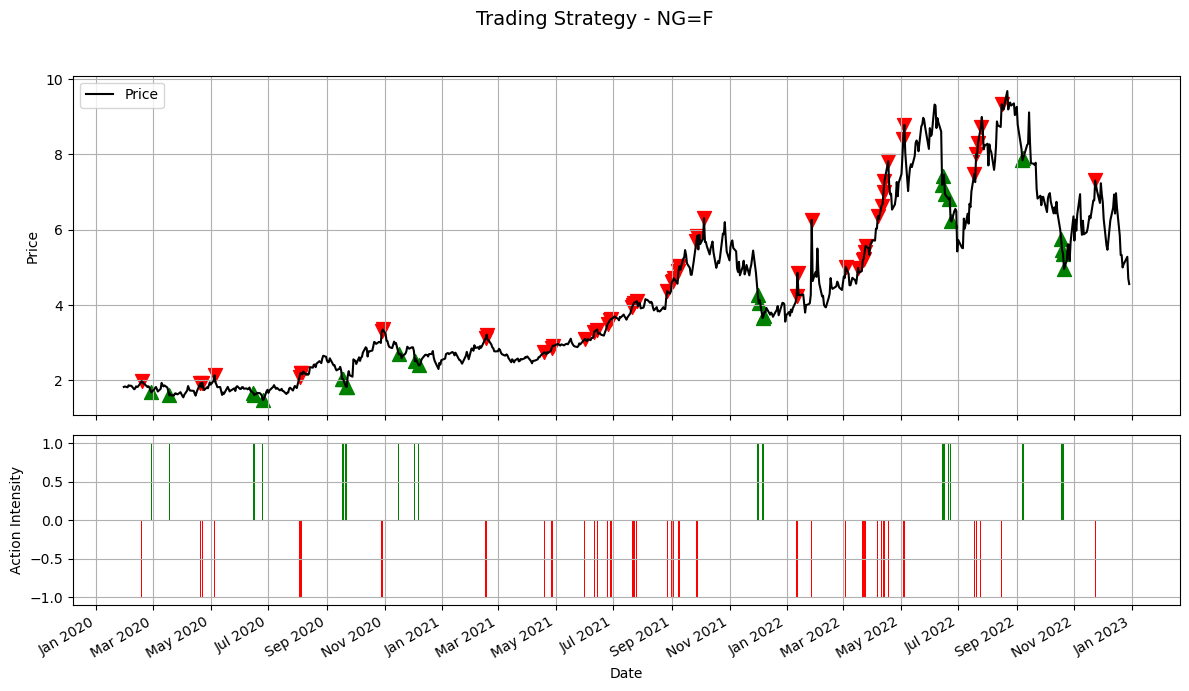

In [69]:
def plot_trading_strategy(env, model, n_steps=200):
    """
    Visualise la stratégie de trading pour chaque actif :
      - Courbe de prix avec markers achat/vente
      - Barres d'intensité (entre -1 et 1)
      - Axe x avec dates formatées (mois)
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    obs = env.reset()
    done = False
    step_count = 0

    # Initialize histories for each ticker using the underlying environment (assumes single env)
    underlying_env = env.envs[0] if hasattr(env, "envs") else env
    tickers = underlying_env.tickers
    price_history = {ticker: [] for ticker in tickers}
    action_history = {ticker: [] for ticker in tickers}
    date_history = []

    while not done and step_count < n_steps:
        step_count += 1

        # Get action from the baseline agent (which returns a discrete integer action)
        action, _ = model.predict(obs)

        # If the underlying environment provides decode_action, use it; otherwise assume single asset
        if hasattr(underlying_env, "decode_action"):
            decoded_actions = underlying_env.decode_action(action)
        else:
            decoded_actions = [action]

        current_step_in_env = underlying_env.current_step
        # Get current date from the first ticker's DataFrame index
        date_index = underlying_env.commodity_data[tickers[0]].index[current_step_in_env]
        date_history.append(date_index)

        for i, ticker in enumerate(tickers):
            price = underlying_env.commodity_data[ticker]['Close'].iloc[current_step_in_env]
            price_history[ticker].append(price)
            # Record the action intensity for the ticker.
            # (If your baseline agent returns signals like 0.5 / -0.5, they will be used here.)
            action_history[ticker].append(decoded_actions[i])

        # Step the environment with the action packaged as a list
        obs, reward, done, info = env.step([action])

    # Plot for each ticker
    for ticker in tickers:
        fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True, height_ratios=[2, 1])
        fig.suptitle(f"Trading Strategy - {ticker}", fontsize=14)

        # --- PRICE CURVE with BUY/SELL markers
        axs[0].plot(date_history, price_history[ticker], label="Price", color='black', linewidth=1.5)
        for i, act in enumerate(action_history[ticker]):
            if act > 0:
                axs[0].scatter(
                    date_history[i],
                    price_history[ticker][i],
                    marker='^',
                    color='green',
                    s=100,
                    label='Buy' if i == 0 else ""
                )
            elif act < 0:
                axs[0].scatter(
                    date_history[i],
                    price_history[ticker][i],
                    marker='v',
                    color='red',
                    s=100,
                    label='Sell' if i == 0 else ""
                )
        axs[0].set_ylabel("Price")
        axs[0].legend(loc='upper left')
        axs[0].grid(True)

        # --- ACTION INTENSITY BARS
        intensities = action_history[ticker]
        colors = ['green' if a > 0 else 'red' if a < 0 else 'gray' for a in intensities]
        axs[1].bar(date_history, intensities, color=colors, width=1)
        axs[1].set_ylabel("Action Intensity")
        axs[1].set_xlabel("Date")
        axs[1].grid(True)

        # --- Date formatting
        axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        fig.autofmt_xdate()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

nb_days = env_test.envs[0].max_steps
plot_trading_strategy(env_test, best_model, n_steps=nb_days)